In [1]:
import convokit

output_dir = "data\\Arknights_plot\\corpus"
# Load the corpus from the saved directory
corpus = convokit.model.corpus.Corpus(output_dir)

In [2]:
import lucem_illud

In [2]:
utt_df = corpus.get_utterances_dataframe()

utt_df

,timestamp,text,speaker,reply_to,conversation_id,meta.story,meta.tokenized_sents,meta.normalized_sents,vectors
id,,,,,,,,,
utt_0,0,It's been a long time since we've last seen...,non-character,None,utt_0,main_0_Evil Time Part 1,"[[It, 's, been, a, long, time, since, we, 've,...","[[long, time, ve, seen], [time], [ve, teeterin...",[]
utt_1,1,...consciousness... Circulation resumed....,Distant Voice,None,utt_1,main_0_Evil Time Part 1,"[[consciousness, Circulation, resumed, vitals,...","[[consciousness, circulation, resumed, vitals,...",[]
utt_2,2,...... Doctor... ...hand! Take my....,???,None,utt_1,main_0_Evil Time Part 1,"[[], [Doctor, hand], [Take, my, Take, my, hand...","[[], [doctor, hand], [hand], [], [emergency], ...",[]
utt_3,3,"Amiya! Don't panic, just calm down first!",Medic,None,utt_1,main_0_Evil Time Part 1,"[[Amiya], [Do, n't, panic, just, calm, down, f...","[[amiya], [panic, calm]]",[]
utt_4,4,Ah... S-sorry.,Amiya,None,utt_1,main_0_Evil Time Part 1,"[[Ah, S, sorry]]","[[ah, s, sorry]]",[]
...,...,...,...,...,...,...,...,...,...
utt_88488,88488,This mission was originally meant for the La...,???,None,utt_88481,act9mini_Pinus Sylvestris,"[[This, mission, was, originally, meant, for, ...","[[mission, originally, meant, lazurites, recom...",[]
utt_88489,88489,Confirmed... It's a match.,Platinum,None,utt_88481,act9mini_Pinus Sylvestris,"[[Confirmed], [It, 's, a, match]]","[[confirmed], [match]]",[]
utt_88490,88490,Very good. Do not disappoint us.,???,None,utt_88481,act9mini_Pinus Sylvestris,"[[Very, good], [Do, not, disappoint, us]]","[[good], [disappoint]]",[]


In [3]:
# Store a csv file of the utterances
# change index to id column, include text, speaker, conversation_id, meta.story

utt_df.to_csv("data\\Arknights_plot\\utterances.csv", index=True)



## tokenize and normalize using lucem_illud

In [ ]:
from openai import OpenAI
client = OpenAI()

def get_embedding(text, model="text-embedding-3-large"):
   text = text.replace("\n", " ")
   return client.embeddings.create(input = [text], model=model).data[0].embedding

In [ ]:
def get_dialogue_text(utterance):
    text = ""
    speaker = utterance.speaker.id
    dialogue = utterance.text

    text += f"{speaker}: {dialogue}\n"

def get_conversation_text(convo_id):
    text = ""

    for utt in corpus.get_conversation(convo_id).iter_utterances():
        text += get_dialogue_text(utt)
    
    return text


In [ ]:
from openai import OpenAI
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm.auto import tqdm  # for the loading bar

client = OpenAI()

def get_embedding(text, model="text-embedding-3-large"):
    text = text.replace("\n", " ")
    response = client.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

def get_dialogue_text(utterance):
    speaker = utterance.speaker.id
    dialogue = utterance.text
    return f"{speaker}: {dialogue}\n"

def get_conversation_text(convo_id):
    text = ""
    for utt in corpus.get_conversation(convo_id).iter_utterances():
        text += get_dialogue_text(utt)
    return text

def process_conversation(convo_id):
    convo_text = get_conversation_text(convo_id)
    embedding = get_embedding(convo_text)
    corpus.get_conversation(convo_id).meta['openai_embedding'] = embedding

# List of all conversation IDs in the corpus
conversation_ids = [convo.id for convo in corpus.iter_conversations()]



num_workers = 25  # Adjust this to the desired number of workers

# Using ThreadPoolExecutor with the specified number of workers for parallel processing
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Creating a list of futures
    futures = [executor.submit(process_conversation, convo_id) for convo_id in conversation_ids]
    
    # Using tqdm to display a loading bar
    for future in tqdm(as_completed(futures), total=len(conversation_ids)):
        _ = future.result()  # getting the result to handle exceptions if any



In [5]:
def tokenize_and_normalize(text):
    tokenized_sents = [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(text)]
    normalized_sents = [lucem_illud.normalizeTokens(s, lemma=False) for s in tokenized_sents]
    return tokenized_sents, normalized_sents

# Iterate over all utterances in the corpus and apply the function
for utterance in corpus.iter_utterances():
    text = utterance.text
    tokenized, normalized = tokenize_and_normalize(text)
    utterance.meta['tokenized_sents'] = tokenized
    utterance.meta['normalized_sents'] = normalized

c:\Users\Admin\anaconda3\envs\Lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [6]:
utt_df = corpus.get_utterances_dataframe()

utt_df

,timestamp,text,speaker,reply_to,conversation_id,meta.story,meta.tokenized_sents,meta.normalized_sents,vectors
id,,,,,,,,,
utt_0,0,It's been a long time since we've last seen...,non-character,None,utt_0,main_0_Evil Time Part 1,"[[It, 's, been, a, long, time, since, we, 've,...","[[long, time, ve, seen], [time], [ve, teeterin...",[]
utt_1,1,...consciousness... Circulation resumed....,Distant Voice,None,utt_1,main_0_Evil Time Part 1,"[[consciousness, Circulation, resumed, vitals,...","[[consciousness, circulation, resumed, vitals,...",[]
utt_2,2,...... Doctor... ...hand! Take my....,???,None,utt_1,main_0_Evil Time Part 1,"[[], [Doctor, hand], [Take, my, Take, my, hand...","[[], [doctor, hand], [hand], [], [emergency], ...",[]
utt_3,3,"Amiya! Don't panic, just calm down first!",Medic,None,utt_1,main_0_Evil Time Part 1,"[[Amiya], [Do, n't, panic, just, calm, down, f...","[[amiya], [panic, calm]]",[]
utt_4,4,Ah... S-sorry.,Amiya,None,utt_1,main_0_Evil Time Part 1,"[[Ah, S, sorry]]","[[ah, s, sorry]]",[]
...,...,...,...,...,...,...,...,...,...
utt_88488,88488,This mission was originally meant for the La...,???,None,utt_88481,act9mini_Pinus Sylvestris,"[[This, mission, was, originally, meant, for, ...","[[mission, originally, meant, lazurites, recom...",[]
utt_88489,88489,Confirmed... It's a match.,Platinum,None,utt_88481,act9mini_Pinus Sylvestris,"[[Confirmed], [It, 's, a, match]]","[[confirmed], [match]]",[]
utt_88490,88490,Very good. Do not disappoint us.,???,None,utt_88481,act9mini_Pinus Sylvestris,"[[Very, good], [Do, not, disappoint, us]]","[[good], [disappoint]]",[]


In [7]:
path = "data/Arknights_plot/corpus" ## corpus folder 
corpus.dump(path)

## Using gensim word2vec and doc2vec model

Here, I'll illustrate the output of the gensim models I trained using the tokenized text above

### word2vec

In [1]:
word2vec_model_path = "data\\Arknights_plot\\embedding\\arknights_W2V_100_bs0.model"

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from gensim.models import Word2Vec

In [3]:
# Load your model
model = Word2Vec.load(word2vec_model_path)

To see if the modle capture the game culture, we can explore the word vectors of those game specific terms and see how they reside in the space related to each other.

In [6]:
# example terminologies
Locations = ['Chernobog', 'Columbia', 'Kazdel', 'Kazimierz', 
             'Kjerag', 'Laterano', 'Londinium', 'Lungmen', 'Sargon',
             'Ursus', 'Victoria', 'Yumen']

Protagonists = ['Amiya', "Kal'tsit", "Ch'en", 
                  "Silence", "Gavial", 
                  "Nian", "Blaze", 
                  "Closure"]
Antagonists = ['Crownslayer', 'Faust', "Frostnova", "Manfred", 'Patriot',  'Talulah']

Enemy_factions = ['Dublinn','Reunion']

In [14]:
# evaluate the embedding with dimensional reduction

words = (Locations + Protagonists + Antagonists + Enemy_factions)
words = [word.lower() for word in words]

# Get embeddings
embeddings = [model.wv[word] for word in words]

# Apply PCA (20/30)
pca = PCA(n_components=10)
pca_result = pca.fit_transform(embeddings)

# Apply t-SNE (25/30)
tsne = TSNE(n_components=2, verbose=1, perplexity=25, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)

[t-SNE] Computing 27 nearest neighbors...
[t-SNE] Indexed 28 samples in 0.000s...
[t-SNE] Computed neighbors for 28 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 28 / 28
[t-SNE] Mean sigma: 4.036491
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.697086
[t-SNE] KL divergence after 300 iterations: 0.459827


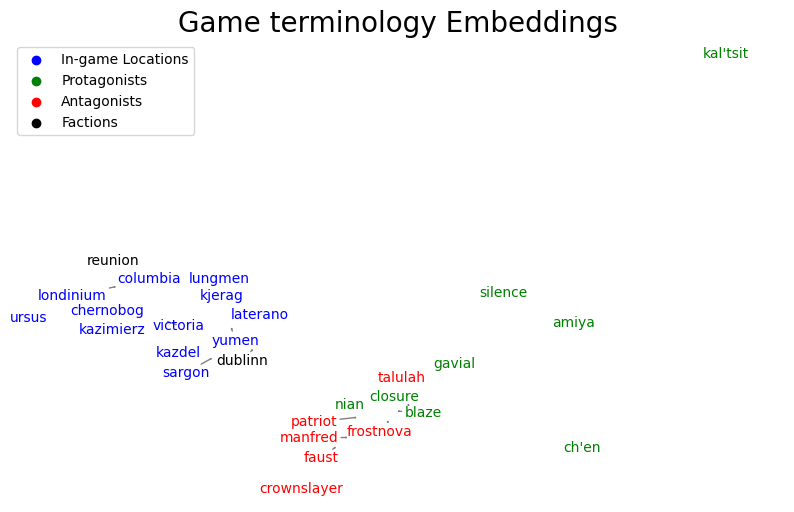

In [20]:
from adjustText import adjust_text

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
# Making the points invisible as before
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0)



texts = []
for i, word in enumerate(words):
    if word.capitalize() in Locations:
        color = 'blue'
    elif word.capitalize() in Protagonists:
        color = 'green'
    elif word.capitalize() in Antagonists:
        color = 'red'
    else:
        color = 'black'

    # Standardizing text size and adding to a list for adjustment
    texts.append(ax.text(pca_result[:, 0][i], pca_result[:, 1][i], word, ha='center', va='center', size=10, color=color))

# Using adjust_text to prevent overlap
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

#title:
plt.title('Game terminology Embeddings', size=20)

for category, color in zip(['In-game Locations', 'Protagonists', 'Antagonists', 'Factions'], ['blue', 'green', 'red', 'black']):
    plt.scatter([], [], color=color, label=category)

# lenged for each color
plt.legend(loc='best')

plt.xticks(())
plt.yticks(())
plt.show()

### Let's compare the word with two models:
- our game model
- google news model

In [4]:
import gensim.downloader as api


google_news_model = api.load('word2vec-google-news-300')

In [10]:
from adjustText import adjust_text

In [14]:
words = [

    "conflict", "peace",
    "war", "death",
    "hero", "leader",
    "weapon", "technology", "art",
    "culture", "society", "government",
    "rich", "poor"
]

In [22]:
embed_game = [model.wv[word] for word in words]
embed_google = [google_news_model[word] for word in words]

In [25]:
pca = PCA(n_components=3)

game_pca = pca.fit_transform(embed_game)
google_pca = pca.fit_transform(embed_google)

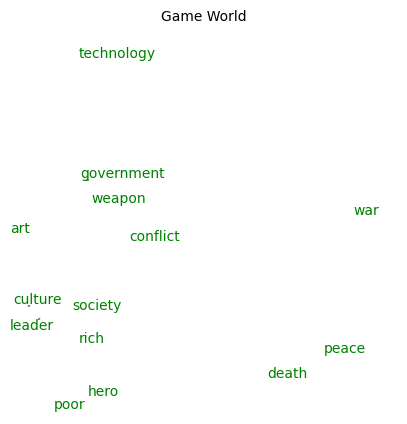

In [26]:
# plot gamepca
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
# Making the points invisible as before
plt.scatter(game_pca[:, 0], game_pca[:, 1], alpha=0)

text=[]
for i, word in enumerate(words):
    #ax.annotate(word, (game_pca[:, 0][i], game_pca[:, 1][i]), size=20 * (len(words) - i) / len(words), color='blue')
    text.append(ax.text(game_pca[:, 0][i], game_pca[:, 1][i], word, ha='center', va='center', size=10, color='green'))

adjust_text(text, arrowprops=dict(arrowstyle='->', color='gray'))
plt.title('Game World', size=10)
plt.xticks(())
plt.yticks(())
plt.show()


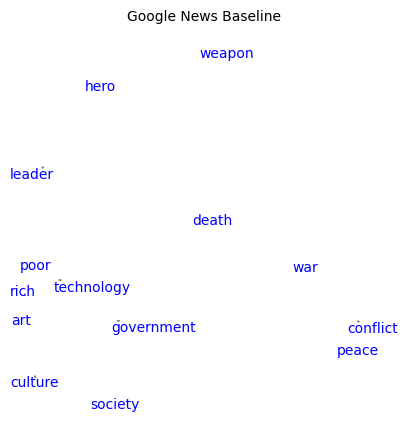

In [27]:
# plot gamepca
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
# Making the points invisible as before
plt.scatter(google_pca[:, 0], google_pca[:, 1], alpha=0)

text=[]
for i, word in enumerate(words):
    #ax.annotate(word, (google_pca [:, 0][i], google_pca [:, 1][i]), size=20 * (len(words) - i) / len(words), color='blue')
    text.append(ax.text(google_pca[:, 0][i], google_pca [:, 1][i], word, ha='center', va='center', size=10, color='blue'))

adjust_text(text, arrowprops=dict(arrowstyle='->', color='gray'))
plt.title('Google News Baseline', size=10)
plt.xticks(())
plt.yticks(())
plt.show()


In [10]:
import csv
def get_conversation_chunks(convo_id, max_length=2000):
    text = ""
    chunks = []
    
    for utt in corpus.get_conversation(convo_id).iter_utterances():
        dialogue_text = get_dialogue_text(utt)
        # Check if adding this dialogue exceeds the max_length
        if len(text + dialogue_text) > max_length:
            # Save current chunk and start a new one
            chunks.append(text)
            text = dialogue_text
        else:
            text += dialogue_text

    # Add the last chunk if it's not empty
    if text:
        chunks.append(text)
    
    return chunks

def process_conversation_chunks(convo_id):
    chunks = get_conversation_chunks(convo_id)
    embeddings = [get_embedding(chunk) for chunk in chunks]
    return convo_id, embeddings

def save_embeddings_to_csv(embeddings_dict, filename="conversation_embeddings.csv"):
    with open(filename, mode="w", newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Text Chunk", "Embedding", "Convo ID"])

        for convo_id, embeddings_list in embeddings_dict.items():
            for i, (text_chunk, embedding) in enumerate(embeddings_list):
                # Convert the embedding array into a string
                embedding_str = " ".join(map(str, embedding))
                # Write the text chunk, its corresponding embedding, and the conversation ID to the CSV
                writer.writerow([text_chunk, embedding_str, convo_id])



In [ ]:
import csv
from concurrent.futures import ThreadPoolExecutor, as_completed
from threading import Lock
from tqdm.auto import tqdm

# Filename for the CSV output
filename = "conversation_embeddings.csv"

# Initialize a lock for thread-safe writing to the CSV file
lock = Lock()

# Open the CSV file and write the header
with open(filename, mode="w", newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Text Chunk", "Embedding", "Convo ID"])

def process_and_write_chunk(convo_id, text_chunk):
    # Process the text chunk to obtain the embedding
    embedding = get_embedding(text_chunk)
    # Convert the embedding array into a string representation
    embedding_str = " ".join(map(str, embedding))
    
    # Acquire the lock before writing to the CSV file
    with lock:
        with open(filename, mode="a", newline='', encoding='utf-8') as file: # use utf-8!!
            writer = csv.writer(file)
            # Write the text chunk, its corresponding embedding, and the conversation ID to the CSV
            writer.writerow([text_chunk, embedding_str, convo_id])

# Adjust the number of workers based on your system's capabilities
num_workers = 10

with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # List to keep track of futures
    futures = []
    
    # Iterate through conversation IDs and their text chunks
    for convo_id in conversation_ids:
        text_chunks = get_conversation_chunks(convo_id)
        for text_chunk in text_chunks:
            # Submit the processing and writing task for each text chunk
            futures.append(executor.submit(process_and_write_chunk, convo_id, text_chunk))

    # Using tqdm to display a loading bar
    for future in tqdm(as_completed(futures), total=len(futures)):
        _ = future.result()  # getting the result to handle exceptions if any


Check if the file contain all the embedding:
- utt_88492 is the last utterance

In [15]:
embedding_file_path = "data\Arknights_plot\embedding\conversation_embeddings_1.csv"
def find_last_processed_convo_id(csv_file_path):
    last_convo_id = None
    try:
        with open(csv_file_path, 'r', encoding='utf-8') as file:
            for line in file:
                if line.strip():  # Check if line is not empty
                    last_line = line
            # Extract the last conversation ID from the last line
            last_convo_id = last_line.split(',')[-1].strip()
    except Exception as e:
        print(f"Error reading the last line of the CSV: {e}")
    return last_convo_id

last_convo_id = find_last_processed_convo_id(embedding_file_path)
print(f"The last processed conversation ID was: {last_convo_id}")

The last processed conversation ID was: utt_88492


#### Q&A using embedding

In [20]:
import pandas as pd
embedding_file_path = "data\Arknights_plot\embedding\conversation_embeddings_1.csv"
chunk_size = 5000
chunks = []

for chunk in pd.read_csv(embedding_file_path, chunksize=chunk_size, encoding= 'utf-8'):
    chunks.append(chunk)

df_embed = pd.concat(chunks, ignore_index=True)

In [19]:
df_embed

,Text Chunk,Embedding,Convo ID
0,Ursus Guard: Curse them... where the hell d...,"[0.02075939252972603, -0.020792875438928604, -...",utt_1
1,Amiya: ... I understand. I know this is ...,"[0.01998366229236126, 0.007341510150581598, -0...",utt_1
2,Amiya: I'd like... to give it a try. Eve...,"[0.031356941908597946, -0.007000225596129894, ...",utt_1
3,Amiya: That's right. It is not enough to on...,"[0.0247239638119936, -0.0342143252491951, -0.0...",utt_1
4,Dobermann: No doubt about it. A Catastrophe ...,"[0.024575579911470413, -0.018330411985516548, ...",utt_1
...,...,...,...
10521,"'Lazurite': You see, it would be very inconv...","[-0.010119310580193996, -0.062104638665914536,...",utt_88477
10522,non-character: It's easy to make a regular Joe...,"[0.05466289445757866, -0.04355096444487572, -0...",utt_88491
10523,non-character: And then he leaves. And there's...,"[0.04670620709657669, -0.029989928007125854, -...",utt_88480
10524,"???: The arena's too small for you, isn't it...","[0.03681131452322006, -0.04066556319594383, -0...",utt_88453


In [21]:
import numpy as np
def string_to_vector(embedding_str):
    # Split the string by spaces and convert each element to float
    return np.array([float(num) for num in embedding_str.split()])
df_embed['Embedding'] = df_embed['Embedding'].apply(string_to_vector)

In [22]:
df_embed['Embedding'][0]

3072

## analyze with embedding

In [11]:
# imports
import ast  # for converting embeddings saved as strings back to arrays
from openai import OpenAI # for calling the OpenAI API
import pandas as pd  # for storing text and embeddings data
import tiktoken  # for counting tokens
import os # for getting API token from env variable OPENAI_API_KEY
from scipy import spatial  # for calculating vector similarities for search
import numpy as np

In [2]:
GPT_MODEL = "gpt-3.5-turbo"
EMBEDDING_MODEL = "text-embedding-3-large"

In [3]:
def strings_ranked_by_relatedness(
    query: str,
    df: pd.DataFrame,
    relatedness_fn=lambda x, y: 1 - spatial.distance.cosine(x, y),
    top_n: int = 100
) -> tuple[list[str], list[float]]:
    """Returns a list of strings and relatednesses, sorted from most related to least."""
    query_embedding_response = client.embeddings.create(
        model=EMBEDDING_MODEL,
        input=query,
    )
    query_embedding = query_embedding_response.data[0].embedding
    strings_and_relatednesses = [
        (row["Text Chunk"], relatedness_fn(query_embedding, row["Embedding"]))
        for i, row in df.iterrows()
    ]
    strings_and_relatednesses.sort(key=lambda x: x[1], reverse=True)
    strings, relatednesses = zip(*strings_and_relatednesses)
    return strings[:top_n], relatednesses[:top_n]

In [4]:
path = 'D:\\MACSS PROGRAM\\30122\\MACS-60000-2024-Winter\\data\\Arknights_plot\\corpus\\conversation_embeddings.csv'
df_embed = pd.read_csv(path)


In [15]:
df_embed["Embedding"][0]

'[ 0.02075939 -0.02079288 -0.00999464 ...  0.00383798 -0.00765921\n -0.00360569]'

In [22]:
df_embed['Embedding'][0].shape # 

(3072,)

In [6]:
client = OpenAI()

In [23]:
strings, relatednesses = strings_ranked_by_relatedness("what is Reunion from Amiya's perspective", df_embed, top_n=5)
for string, relatedness in zip(strings, relatednesses):
    print(f"{relatedness=:.3f}")
    display(string)

relatedness=0.593


"Reunion Member:    That's right, her assault went very smoothly!    Should we also retreat?\nSkullshatterer:    ...    Send a signal to Talulah.\nReunion Member:    Roger!\nSkullshatterer:    ...We're pulling back.    Hmph. Rhodes Island cowards...    The next time we meet... will be at your execution.\nAmiya:    Reunion... is retreating?\nFranka:    They're retreating very rapidly. Something must have changed with their plans.    Despite all that talk, they sure know how to run away.\nAmiya:    ...    Something... doesn't feel right.\nLiskarm:    Are you saying...\nAmiya:    ...!    That they were only here to stall us...?    If that's the case...    Oh no, the L.G.D. is in trouble!    ...We have to help Madam Ch'en right now!    Franka, call the recon squad back immediately!    Liskarm, try to get in touch with Madam Ch'en!\nCh'en:    Where's the Special Operations Division? Their reinforcements are supposed to be here by now!\nL.G.D. Agent:    We were just notified that they've bee

relatedness=0.589


"Reunion Member:    Nngh... Guhh...    Uaaagh!    It hurts... It huuurrtsssss...    Aaagh... Aaaargh! It itches! It itches!!    Graaah?!!    Rhodes... Rhodes Island!    Enemy... Enemy!!\nJessica:    What...! Wh-what's going on...    The enemies we just defeated are standing back up...?\nMephisto:    What? Are you done already?\nFrostleaf:    There's a glow... coming from that guy's staff...?\nMephisto:    I haven't even done anything yet.\nJessica:    And... they've got a lot more reinforcements coming...\nMeteorite:    Curse you...!    Right now, I can only pray that this round can kill the enemy leader...!\nFrostleaf:    Don't.\nMephisto:    Haha... Do you really have time for a strategy meeting in your position?    So much self-confidence.\nMeteorite:    Hmph. I'll teach you a lesson with this shot...\nFrostleaf:    No, Meteorite. Don't.\nMeteorite:    Tsk...! Why?!\nFrostleaf:    We need to retreat.    I can feel it...    It's them. They're here.\nMephisto:    Ohh? You're not going

relatedness=0.587


'Amiya: The revenant...\n'

relatedness=0.583


"Amiya:    Ah, Doctor?    Were you waiting for me this whole time...    Sorry to have kept you waiting.    Hmm? My complexion looks different from when I left?    ...    Some things happened.    I feel like...    Perhaps Madam Ch'en has her own way of looking at things.    Even though her words are harsh, and she has done things that I can't accept...    Maybe... the difference between us isn't that big.    She has her responsibilities.    Oh... I understand now...    She also has her share of burdens to bear.    Perhaps I also...\nAmiya:    Is that so...    I... just didn't have other choices.\nAmiya:    ...I suppose all these consequences were the results of my persistence.    Doctor, there's no need... to try to comfort me.    Actually, I'm well aware of this.    But what I don't know...    What I don't know, is how long we have to keep going before this world begins to change.    But, what I do know for sure...    Is that I won't give up.    I'll always bear the consequences of my 

relatedness=0.583


"Misha:    I don't know anything about this 'Reunion' that you're talking about, but...    But I do know the L.G.D., and I've seen how they treat the Infected. If you wanted me to capture me from the beginning, you should've just said it.\nAmiya:    I'm sorry... But, that's really not our intention. I know there are still some misunderstandings that have to be worked out.    But no matter how bad you think we are... Please, just bear with us a bit longer.    Your safety takes priority over how you feel.    I'll explain everything if I get the chance.    After all, there are still things that I want to know...\nMisha:    ...\nTexas:    ...    Rhodes Island sure is taking their time.    Oh...?\nReunion Member:    We're almost at the interception point!\nTexas:    Tch, finally... I just finished unpacking.    What a waste.\nReunion Member:    Hurry up! Those in the back, follow more closely!\nTexas:    Hey, masked person over there.\nReunion Member:    Who is it? !    What do you want?\nT

In [34]:
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))


def query_message(
    query: str,
    df: pd.DataFrame,
    model: str,
    token_budget: int
) -> str:
    """Return a message for GPT, with relevant source texts pulled from a dataframe."""
    strings, relatednesses = strings_ranked_by_relatedness(query, df)
    introduction = """
    These are some dialogue from the fictional world.
    Try to infer about the world based on the dialogue and try your best to answer the questions.
    You can ask for more information.
    """
    question = f"\n\nQuestion: {query}"
    message = introduction
    for string in strings:
        next_article = f'\n\nDialogues:\n"""\n{string}\n"""'
        if (
            num_tokens(message + next_article + question, model=model)
            > token_budget
        ):
            break
        else:
            message += next_article
    return message + question


def ask(
    query: str,
    df: pd.DataFrame = df_embed,
    model: str = GPT_MODEL,
    token_budget: int = 4096 - 500, #consider budget
    print_message: bool = False,
) -> str:
    """Answers a query using GPT and a dataframe of relevant texts and embeddings."""
    message = query_message(query, df, model=model, token_budget=token_budget)
    if print_message:
        print(message)
    messages = [
        {"role": "system", "content": "You answer questions about the fictional world of 'Arknights'."},
        {"role": "user", "content": message},
    ]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0
    )
    response_message = response.choices[0].message.content
    return response_message

In [35]:
ask("Who is the leader of the Reunion?")

'The leader of the Reunion is known as Talulah.'

In [36]:
ask("Try to talk about what is reunion from Amiya's perspective.")

"From the dialogues provided, it is clear that Reunion is a significant faction within the world of Arknights. Amiya's perspective on Reunion seems to be complex and multifaceted. She acknowledges that Reunion members are individuals who are facing difficult circumstances and are seeking refuge from various threats, including the Sarkaz and guerrillas. Amiya shows empathy towards Reunion members, understanding their fears and concerns.\n\nAmiya also recognizes the actions of Reunion, such as infiltrating Lungmen and causing turmoil, as well as their clashes with Rhodes Island and the L.G.D. She seems to view Reunion as a group that is driven by desperation and a sense of being cornered, leading them to take extreme measures.\n\nDespite the conflicts and differences between Rhodes Island and Reunion, Amiya tries to find common ground and offers assistance to Reunion members who are willing to protect bystander Infected individuals. She emphasizes the importance of understanding the trut

In [37]:
ask("What is the differences between Sarkaz and Sankta?")

'Based on the dialogues provided, it seems that Sarkaz and Sankta are two distinct races within the world of Arknights with significant cultural and historical differences:\n\n1. **Sarkaz**:\n   - The Sarkaz are depicted as a proud and fierce race who have faced oppression, displacement, and conflict throughout their history.\n   - They are shown to have a strong sense of identity and unity, as seen in their resistance against invaders and their determination to rebuild their homeland.\n   - The Sarkaz are associated with traits such as rage, vengeance, and a history of conflict with other races, particularly the Sankta.\n   - There are references to the Sarkaz being victims of slaughter, oppression, and displacement, leading to a deep-rooted sense of injustice and a desire for retribution.\n\n2. **Sankta**:\n   - The Sankta are portrayed as a more established and privileged race, with a presence in holy cities like Laterano.\n   - They are shown to have a religious and hierarchical so

### Huge embedding

In [2]:
large_path = "data\\Arknights_plot\\embedding\\utterance_embeddings.json"

In [ ]:
# see what the data looks like
# it's a large file, only load the first element

import json
with open(large_path, 'r') as file:
    data = json.load(file)

data

In [7]:
len(data)

88465

In [ ]:
# see a sample key value pair

data.keys()

In [17]:
from pinecone import Pinecone

pc = Pinecone(api_key="907c3690-d6e7-48e6-bc73-531431a072da")
index = pc.Index("arknights-utterance-embeddings")

In [23]:
combined_data = (
        (name, embedding, utt_df.loc[name, 'meta.story'], utt_df.loc[name, 'speaker'], utt_df.loc[name, 'text'])
        for name, embedding in data.items()
)

In [24]:
import itertools

def chunks(iterable, batch_size=100):
    """A helper function to break an iterable into chunks of size batch_size."""
    it = iter(iterable)
    chunk = tuple(itertools.islice(it, batch_size))
    while chunk:
        yield chunk
        chunk = tuple(itertools.islice(it, batch_size))

def upsert_data_to_pinecone(data, utt_df, index, batch_size=100):
    """
    Upsert data and metadata into Pinecone index.

    Args:
        data (dict): Dictionary where keys are names and values are embeddings.
        utt_df (pandas.DataFrame): DataFrame containing metadata, index matching the names in `data`.
        index (pinecone.Index): Pinecone index object.
        batch_size (int): Number of records to upsert in each batch.
    """
    # Generate combined data with metadata
    combined_data = (
        (name, embedding, utt_df.loc[name, 'meta.story'], utt_df.loc[name, 'speaker'], utt_df.loc[name, 'text'])
        for name, embedding in data.items()
    )

    # Function to format data for Pinecone
    def format_for_pinecone(chunk):
        return [
            {
                "id": name,
                "values": embedding,
                "metadata": {"story": story, "speaker": speaker, "text": text}
            }
            for name, embedding, story, speaker, text in chunk
        ]

    # Upsert data in chunks
    for chunk in chunks(combined_data, batch_size=batch_size):
        formatted_chunk = format_for_pinecone(chunk)
        index.upsert(vectors=formatted_chunk)

In [26]:
with pc.Index('arknights-utterance-embeddings', pool_threads=30) as index:
   upsert_data_to_pinecone(data, utt_df, index, batch_size=100)

: 